## 계수축소법
- 계수 축소법(Shrinkage)은 회귀모델에서 주로 사용하는 방법으로, 출력변수(Y) 예측에 영향력이 없는 입력변수(X)의 **회귀계수**를 0으로 (혹은 가깝게) 만들어 입력변수의 수를 줄이는 방법
- **과적합과 다중공선성을 방지** 할 수 있는 선형회귀 기법
- 잔차(Residual)만을 최소화하는 다중선형회귀와 달리, 계수 축소법에서는 규제항을 통해 잔차와 회귀계수를 동시에 최소화 함
$$Minimize\quad SSE + f(\hat\beta)$$
- 대표적인 계수 축소법으로는 [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)가 있음
    - Ridge는 규제항으로 '회귀계수의 제곱합' 사용 (Lambda가 커질수록 보다 많은 회귀계수를 **0에 가깝게** 만듬)
    - Lasso는 규제항으로 '회귀계수의 절대값 합' 사용 (Lambda가 커질수록 보다 많은 회귀계수를 **0으로 수렴**시킴)
> 입력변수들이 전반적으로 비슷한 수준으로 출력변수에 영향을 미치는 경우에는 Ridge, 입력변수의 영향력 편차가 큰 경우에는 Lasso가 좋은 성능을 보일 확률이 높다.

**Ridge, Lasso 주요 하이퍼 파라미터**
- alpha : lambda와 동일, default = 1.0(float), 0일시 OLS기반 선형회귀와 동일
- max_iter : 최대 반복 횟수, default = 1000
- normalize : bool(True or False), default = False, True일시 (입력변수-mean)/L2_norm 으로 정규화



### 1. 데이터 로드 및 전처리

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
data=pd.read_csv("./data/Fault_data.csv",encoding="EUC-KR")
data.drop(["자재구분","END_DATE_TIME"],axis=1,inplace=True) # 분석에 필요없는 column 제거
data.dropna(axis=1,inplace=True) # NaN값이 존재하는 열 제거

In [3]:
print("==== 수치 변화가 아예 없는 변수 제거 ====")
for i in data.columns:
    if len(data[i].unique())==1: # if 특정 column의 고유값이 한개이면(=수치변화가 없으면)
        data = data.drop([i],axis=1) # 해당 변수 제거
        print(i)

==== 수치 변화가 아예 없는 변수 제거 ====
CROT.STDDEV0
CROT.RANGE0
CROT.STDDEV1
CROT.RANGE1
CROT.STDDEV13
CROT.RANGE13
CROT.STDDEV5
CROT.RANGE5
CROT.STDDEV11
CROT.RANGE11
CROT.STDDEV10
CROT.RANGE10
CROT.STDDEV7
CROT.RANGE7
CROT.STDDEV14
CROT.RANGE14
CROT.STDDEV12
CROT.RANGE12
CROT.STDDEV9
CROT.RANGE9


In [4]:
data.shape

(139, 117)

In [5]:
#X,Y 분할
Y=data["Y"].copy()
X=data.drop("Y",axis=1)
X.head(3)

,CHAMBER,TAE.STDDEV0,TAE.MEAN0,TAE.RANGE0,PC.STDDEV0,PC.MEAN0,PC.RANGE0,CROT.MEAN0,TAE.STDDEV1,TAE.MEAN1,...,PC.STDDEV12,PC.MEAN12,PC.RANGE12,TAE.STDDEV9,TAE.MEAN9,TAE.RANGE9,CROT.MEAN9,PC.STDDEV9,PC.MEAN9,PC.RANGE9
0,4,0.044554,38.083127,0.254154,0.124753,0.044329,0.439883,35,0.121240,38.055619,...,3.821034,57.645580,17.350926,0.032832,35.011650,0.127077,35,0.405343,45.124841,3.079182
1,2,0.034801,38.052395,0.063538,0.177575,0.342131,0.439883,27,0.115462,38.016088,...,0.303504,56.613882,1.466280,0.020858,35.550245,0.063540,27,1.923012,45.350277,15.004887
2,3,0.030089,38.046407,0.127080,0.137559,0.063983,0.488759,15,0.119149,38.029244,...,2.845739,57.296468,13.098728,0.021635,36.013373,0.063538,15,0.161640,45.071393,0.977516


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.3,random_state=0) # test_size : float or int, int값일시 test data로 분류할 만큼의 sample수
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape) # 각 데이터셋의 shape 출력

(97, 116) (42, 116) (97,) (42,)


In [7]:
# 평가 지표 출력 함수
def print_all_reg(Y_test,pred):
    print("model의 MSE 값은 {:.3f}".format(mean_squared_error(Y_test,pred)))
    print("model의 MAE 값은 {:.3f}".format(mean_absolute_error(Y_test, pred)))
    print("model의 r2 값은 {:.3f}".format(r2_score(Y_test, pred)))

### 2. 계수 축소법 모델 적용

In [8]:
# 하이퍼파라미터는 디폴트 설정 (alpha = 1)
from sklearn.linear_model import Lasso
Lasso_model=Lasso(max_iter = 10000000) # 최대 반복횟수 설정
Lasso_model.fit(X_train, Y_train)
la_pred=Lasso_model.predict(X_test)
print_all_reg(Y_test,la_pred) # 평가지표 출력

model의 MSE 값은 3009.677
model의 MAE 값은 42.333
model의 r2 값은 0.375


In [9]:
from sklearn.linear_model import Ridge
ridge=Ridge().fit(X_train, Y_train)
ri_pred=ridge.predict(X_test)
print_all_reg(Y_test,ri_pred)

model의 MSE 값은 3279.402
model의 MAE 값은 43.003
model의 r2 값은 0.319


### 3. 계수축소법 모델 적용 후 회귀 계수 

In [10]:
np.where(Lasso_model.coef_)[0]

array([  0,   4,  13,  14,  20,  28,  30,  34,  36,  44,  53,  60,  67,
        70,  82,  83,  89,  95, 101, 108, 115], dtype=int64)

참고 : [pyplot.stem](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.stem.html)

C:\Users\HG\AppData\Local\Temp\ipykernel_2592\162736487.py:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  m, s, _ = plt.stem(
C:\Users\HG\AppData\Local\Temp\ipykernel_2592\162736487.py:12: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  m, s, _ = plt.stem(


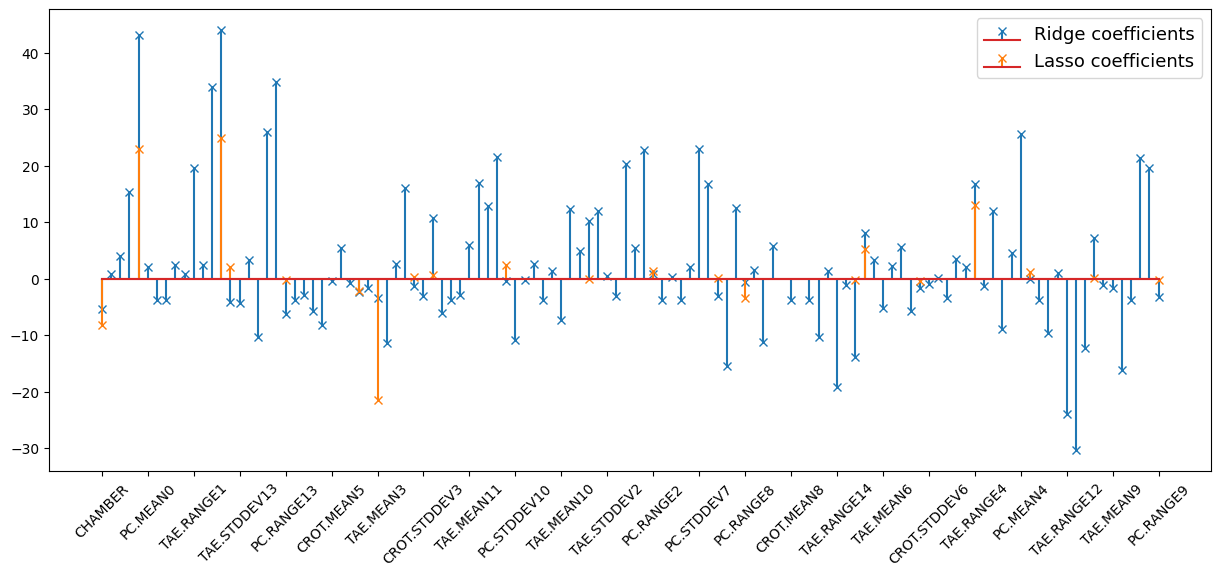

In [11]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (15,6)
m, s, _ = plt.stem(
    np.where(ridge.coef_)[0], # 학습한 Ridge모델의 회귀계수중, 0이 아닌 값을 갖는 index를 array로 반환.
    ridge.coef_[ridge.coef_ != 0], # 0이아닌 회귀계수값 반환. Ridge는 회귀계수가 0이되진 않으므로 전체 회귀계수값이 해당.
    markerfmt="x",
    label="Ridge coefficients",
    use_line_collection=True,
)


m, s, _ = plt.stem(
    np.where(Lasso_model.coef_)[0], # 모델 회귀계수 중, 0이아닌 값의 index 반환
    Lasso_model.coef_[Lasso_model.coef_ != 0], # 0이아닌 회귀계수 값 반환
    markerfmt="x",
    label="Lasso coefficients",
    use_line_collection=True,
)

#글씨
labels = X_train.columns
plt.xticks(ticks=list(range(len(labels))), labels=labels, rotation=45)
plt.locator_params(axis='x', nbins=len(labels)/5)
plt.setp([m, s], color="#ff7f0e")
plt.legend(loc = 'best',fontsize= 13)
plt.show()
plt.close('all')